In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import nltk
import numpy as np
import pandas as pd
import spacy
import sys
import json

from collections import defaultdict, Counter
from gensim.models import KeyedVectors
from nltk import sent_tokenize
from tqdm import tqdm_notebook
nltk.download('stopwords')
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('spanish')
nltk.download("punkt")
spacy.cli.download("es")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [25]:
with open("/content/drive/My Drive/result",'r') as fp:
  noticia = fp.read()
news = json.loads(noticia)
new_d = {}
for d in news:
  if len(news[d]['titulo']+". "+news[d]['resumen']) > 100:
    new_d[d]={}
    new_d[d]['etiquetas'] = []
    for k in news[d].keys():
      if 'etiqueta' in k and 'GALERÍA' not in news[d]['etiquetas']:
        new_d[d]['etiquetas'] = news[d][k]
      if 'temas' in k:
        new_d[d]['temas'] = news[d][k]
      if 'fecha' in k:
        new_d[d]['fecha'] = news[d][k]
      if 'resumen' in k:
        new_d[d]['resumen'] = news[d][k]
      if 'titulo' in k:
        new_d[d]['titulo'] = news[d][k]
  else:
    pass
news = new_d

In [26]:
nlp = spacy.load("es")
news_to_index = {new: idx for idx, new in enumerate(sorted(news.keys()))}
news_features_list = [news[w] for w in sorted(news.keys())]
df = pd.DataFrame(news)

In [27]:
dataset = []
for new in sorted(news.keys()):
  s = news[new]['titulo']+". "+news[new]['resumen']
  dataset.append(s)
entities = []
for new in news:
  for etiq in news[new]['etiquetas']:
    if etiq != '' and etiq[0].isupper() and etiq not in entities:
      entities.extend([etiq])

themes = []
for new in news:
  if news[new]['temas'] not in themes:
    themes.append(news[new]['temas'])

In [28]:
%%time
with open("/content/drive/My Drive/noticias.conll", "w") as fh:
  for d in dataset:
    for sentence in sent_tokenize(d, language="spanish"):
      for token in nlp(sentence):
        if not token.is_stop and not token.is_punct:
          print(token.text, token.lemma_, token.pos_, token.dep_, token.head,
                      file=fh)
      print(file=fh)
    print("="*80, file=fh)

CPU times: user 2min 29s, sys: 58.9 ms, total: 2min 29s
Wall time: 2min 29s


In [29]:
def conll_iterator(file, ner=False):
    context = []
    print(file)
    with open(file, "r") as fh:
        for line in fh:
            if line.strip() == "":
                yield context
                context = []
            elif line.strip() == ("=" * 80):
                yield context
                continue
            else:
              try:
                if ner == True:
                  info = line.strip()
                else:
                  (token, lemma, pos, dep, head) = line.strip().split()
              except ValueError:
                  continue
              if ner == False:
                  context.append({
                    "token": token,
                    "lemma": lemma,
                    "pos": pos,
                    "dep": dep,
                    "head": head
                  })
              else:
                  context.append({
                    "token": info
                  })

for corpus in conll_iterator('/content/drive/My Drive/noticias.conll'):
    print(corpus)
    break

/content/drive/My Drive/noticias.conll
[{'token': 'Jóvenes', 'lemma': 'Jóvenes', 'pos': 'NOUN', 'dep': 'nsubj', 'head': 'innovan'}, {'token': 'argentinos', 'lemma': 'argentino', 'pos': 'ADJ', 'dep': 'amod', 'head': 'Jóvenes'}, {'token': 'innovan', 'lemma': 'innovar', 'pos': 'VERB', 'dep': 'ROOT', 'head': 'innovan'}, {'token': 'drones', 'lemma': 'drones', 'pos': 'NOUN', 'dep': 'obl', 'head': 'innovan'}, {'token': 'subacuáticos', 'lemma': 'subacuático', 'pos': 'ADJ', 'dep': 'amod', 'head': 'drones'}, {'token': 'snacks', 'lemma': 'snack', 'pos': 'VERB', 'dep': 'advcl', 'head': 'innovan'}, {'token': 'saludables', 'lemma': 'saludable', 'pos': 'ADJ', 'dep': 'flat', 'head': 'snacks'}, {'token': 'e', 'lemma': 'e', 'pos': 'CONJ', 'dep': 'cc', 'head': 'iluminación'}, {'token': 'iluminación', 'lemma': 'iluminación', 'pos': 'NOUN', 'dep': 'conj', 'head': 'snacks'}, {'token': 'sustentable', 'lemma': 'sustentable', 'pos': 'ADJ', 'dep': 'amod', 'head': 'iluminación'}]


In [30]:
words_features = {}
documents_features = []
document_feature = {}
for context in conll_iterator("/content/drive/My Drive/noticias.conll"):
  if context == []:
    for k in words_features.keys():
      if k not in documents_features:
        document_feature[k] = 0
      document_feature[k] += 1 
    documents_features.append(document_feature)
    document_feature = {}
    words_features = {}
    title = True
  if context != []:
    for idx, word in enumerate(context):
      lemma = word["lemma"]
      if lemma in words_features:
        word_features = words_features[lemma]
      else:
        word_features = {}
      
      features = [
          "token__{}".format(word["token"]),
          "pos__{}".format(word["pos"]),
          "dep__{}__{}".format(word["dep"], word["head"])
      ]
      
      for feature in features:
        if feature not in word_features:
          word_features[feature] = 0
        word_features[feature] += 1
      
      if 0 < idx < len(context) - 1:
        previous_word = context[idx-1]
        next_word = context[idx+1]
        s = previous_word['lemma'] + ' ' + context[idx]['lemma'] + ' ' + next_word['lemma']
        previous_word_lemma = context[idx-1]["lemma"]
        features = [
          "3gram__{}".format(s)
        ]

        for feature in features:
          if feature not in word_features:
            word_features[feature] = 0
          word_features[feature] += 1
        

        for feature in features:
          if feature not in word_features:
            word_features[feature] = 0
          word_features[feature] += 1

      words_features[lemma] = word_features

/content/drive/My Drive/noticias.conll


In [ ]:
documents_features

[{'Drones': 1,
  'Innovar': 1,
  'Jóvenes': 1,
  'alto': 1,
  'argentino': 1,
  'central': 1,
  'concursar': 1,
  'desarrollo': 1,
  'distinguir': 1,
  'drones': 1,
  'e': 1,
  'gradar': 1,
  'iluminación': 1,
  'impactar': 1,
  'innovar': 1,
  'inspeccionar': 1,
  'interior': 1,
  'inventor': 1,
  'joven': 1,
  'máquina': 1,
  'novedad': 1,
  'nuclear': 1,
  'productor': 1,
  'saludable': 1,
  'sistema': 1,
  'snack': 1,
  'social': 1,
  'subacuático': 1,
  'sustentable': 1,
  'y': 1},
 {'24': 1,
  'Aires': 1,
  'Che': 1,
  'Coliqueo': 1,
  'Joven': 1,
  'Marino': 1,
  'Pablo': 1,
  'año': 1,
  'cepa': 1,
  'cerrar': 1,
  'ciclar': 1,
  'ciudad': 1,
  'comprometer': 1,
  'despedir': 1,
  'domingo': 1,
  'escenario': 1,
  'folclórico': 1,
  'formación': 1,
  'girar': 1,
  'irrumpir': 1,
  'letra': 1,
  'liderar': 1,
  'noche': 1,
  'teatro': 1,
  'y': 1},
 {'Mandraccio': 1,
  'Paula': 1,
  'a': 1,
  'ayudarte': 1,
  'circular': 1,
  'empoderar': 1,
  'equipar': 1,
  'liderazgo': 1,
  '

In [31]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=True)
word_matrix = vectorizer.fit_transform(documents_features)

In [32]:
from sklearn.cluster import KMeans
n=700
model = KMeans(n_clusters=n)
naive_clusters = model.fit(word_matrix)

In [33]:
def get_metric(cluster):
  clusters_per_word = list(zip(sorted(news_to_index.keys()), cluster.labels_))
  l = {}
  proportion = 0
  for i in range(max(cluster.labels_)):
    metrics= {}
    cluster = [w for w, c in clusters_per_word if c == i]
    if len(cluster) > 1:
      print(i,'=====================================================================')
      for c in cluster:
        m = news_to_index[c]
        temas = news_features_list[m]['temas'].split('-')
        temas.extend(news_features_list[m]['etiquetas'])
        for tema in temas:
          t = tema.lower()
          if t not in metrics.keys():
            metrics[t] = 0.0
          metrics[t] += 1.0
      metrics.update((x, y/len(cluster)) for x, y in metrics.items())
      for m in metrics.keys():
        proportion += metrics[m]
      proportion=proportion/len(metrics)
      l[i] = proportion
      print(proportion)
      proportion = 0
      print(metrics)
    elif len(cluster) == 1:
      l[i] = 1
    else:
      l[i] = 0

  
  print('resultado:', sum(l.values())/len(l))
  return l, clusters_per_word

naive_metrics, naive_clusters_per_word=get_metric(naive_clusters)

0 =====================================================================
0.7916666666666666
{'elecciones': 1.0, 'unlp': 1.5, 'la plata': 2.0, 'argentina': 1.0, 'universidad': 0.5, 'bicicletas': 0.5, 'discapacidad': 0.5, 'estudiantes': 0.5, 'transporte': 0.5, 'becas': 0.5, 'alquiler': 0.5, 'hijo': 0.5}
1 =====================================================================
0.7666666666666666
{'granos': 1.3333333333333333, 'usda': 1.3333333333333333, 'trigo': 1.0, 'maíz': 0.3333333333333333, 'soja': 0.3333333333333333, 'buenos aires': 1.0, 'argentina': 1.0, 'exportaciones': 0.3333333333333333, 'sequía': 0.6666666666666666, 'bolsa de comercio de rosario': 0.3333333333333333}
2 =====================================================================
0.10547945205479436
{'transporte': 0.15, 'buenos aires ': 0.05, 'accesibilidad': 0.05, 'buenos aires': 1.0, 'argentina': 1.0, 'pymes': 0.3, 'financiamiento': 0.25, 'emprendedores': 0.05, 'pnud': 0.05, 'cnv': 0.2, 'fideicomisos': 0.05, 'participació

In [34]:
def best_clusters(metrics, clusters_per_word):
  maximos = sorted(metrics.values(),reverse = True)[:20]
  idxs=[]
  for idx in metrics.keys():
    if metrics[idx] in maximos:
      idxs.append(idx)
  print(maximos)
  for idx in idxs:
    print(idx,"==================")
    cluster = [w for w, c in clusters_per_word if c == idx]
    for c in cluster:
      m = news_to_index[c]
      print(news_features_list[m]['titulo'] + '. ' + news_features_list[m]['resumen'])

best_clusters(naive_metrics, naive_clusters_per_word)

[1.75, 1.6, 1.6, 1.6, 1.5, 1.5, 1.5, 1.4666666666666666, 1.4166666666666667, 1.4, 1.3571428571428572, 1.3333333333333333, 1.3333333333333333, 1.3333333333333333, 1.3333333333333333, 1.3125, 1.3, 1.3, 1.25, 1.25]
15 ==================
Luis Verón y Anahí Sánchez, la presencia argentina mañana en Londres. El bonaerense Luis Alberto Verón, campeón latino welter OMB (Organización Mundial de Boxeo) se medirá mañana con el campeón europeo de la categoría, el inglés Michael McKinson, en uno de los combates estelares de la velada a desarrollarse en el York Hall de Bethnal Green, Londres.
Los argentinos Luis Verón y Anahí Sánchez perdieron sus combates en Londres. El bonaerense Luis Alberto Verón, campeón latino welter OMB (Organización Mundial de Boxeo) perdió hoy por puntos con el campeón europeo de la categoría, el inglés Michael McKinson, en uno de los combates estelares de la velada desarrollada en el York Hall de Bethnal Green, Londres.
33 ==================
Con dos partidos se inicia maña

In [44]:
def get_dist(clusters):
  dist=[]
  for i in range(max(clusters.labels_)):
    dist.append([])
    for j in range(max(clusters.labels_)):
      dist[i].append(np.linalg.norm(clusters.cluster_centers_[i]-clusters.cluster_centers_[j]))
  return dist

In [109]:
def index_dist(l,v):
  for i in range(len(l)):
    if v == l[i]:
      r = i
  return r

def tags_per_cluster(cpw,label):
  cluster = [w for w, c in cpw if c == label]
  tags=[]
  for c in cluster:
    m = news_to_index[c]
    tags.extend(news_features_list[m]['etiquetas'])
  return tags

def get_pmi(cluster,cpw): 
  pmi=[]
  dist = get_dist(cluster)
  for j in range(max(cluster.labels_)):
    mini = sorted(dist[j])[1:6]
    x = tags_per_cluster(cpw, j)
    if len(x) == 0:
      continue
    ratios =[]
    for i in mini:
      minipos = index_dist(dist[j],i)
      y = tags_per_cluster(cpw, minipos)
      if len(y) == 0:
        continue
      r=0
      if len(x) > len(y):
        for tag in x:
          if tag in y:
            r +=1
        r /= len(y)
        r /= (1/len(x))
      else:
        for tag in y:
          if tag in x:
            r +=1
        r /= len(x)
        r /= (1/len(y))
      ratios.append(r)
    pmi.extend(ratios)
  return np.log(sum(pmi)/len(pmi))

In [110]:

get_pmi(naive_clusters, naive_clusters_per_word)

10.391343667778111

# **USANDO DOC2VEC**

In [48]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [49]:
text = []
data = ''
for d in documents_features:
  for key in d:
    data += key + ' '
  text.append(data)
  data = ''
text

['Jóvenes argentino innovar drones subacuático snack saludable e iluminación sustentable Drones inspeccionar interior central nuclear máquina productor y sistema desarrollo joven inventor distinguir concursar Innovar alto gradar novedad impactar social ',
 'Che Joven cerrar ciclar 24 año girar despedir formación liderar Pablo y Marino Coliqueo irrumpir letra comprometer cepa folclórico escenario domingo noche teatro ciudad Aires ',
 'liderazgo circular y ayudarte a empoderar equipar Paula Mandraccio ',
 'Derrotas Cadenas tango desprejuiciado agitar escena contemporáneo formación expresión dueño lenguaje consolidar y identidad definir adelantar cuartar disco Jaula Músicos viernes 15 Teatro Roma Avellaneda sintetizar recorrer resultar haberse liberar prejuicio asumir estético formar librar preciso violinista director Bruno Giuntini ',
 'narración alternativo y actual antihéroe Gauchito Gil Joaquín Pedretti estrenar jueves estético realismo simbólico litro a vida desmitificar ajeno pompa 

In [50]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in text:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed: ', j)

Number of texts processed:  3625


In [51]:
d2v_model = Doc2Vec(all_content_train, size = 100, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


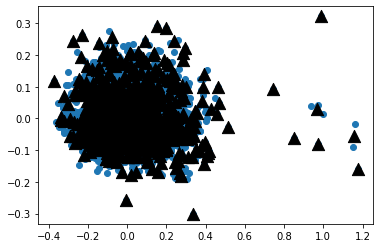

In [52]:
kmeans_model = KMeans(n_clusters=n, init='k-means++', max_iter=100) 
doc2vec_clusters = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(datapoint[:, 0], datapoint[:, 1])
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [53]:
l, d2v_clusters_to_docs = get_metric(doc2vec_clusters)

0 =====================================================================
0.31521739130434784
{'bolivia': 0.75, 'diputados': 0.25, 'justicialismo': 0.25, 'cámara de diputados': 0.25, 'diego bossio': 0.25, 'buenos aires': 0.25, 'argentina': 0.5, 'onu': 0.5, 'golpe de estado': 0.25, 'evo morales': 0.25, 'antónio guterres': 0.25, '': 0.25, 'naciones unidas': 0.25, 'cine': 0.5, 'nicolas cage': 0.5, 'hollywood': 0.25, 'los ángeles': 0.25, 'estados unidos': 0.25, 'hospital de niños': 0.25, 'robo ': 0.25, 'robo': 0.25, 'hospital de niños de la plata': 0.25, 'la plata': 0.25}
1 =====================================================================
0.13875598086124394
{'transición': 0.2727272727272727, 'plaini': 0.09090909090909091, 'sindicalismo': 0.09090909090909091, 'alberto fernández': 0.18181818181818182, 'omar plaini': 0.09090909090909091, 'buenos aires': 0.45454545454545453, 'argentina': 0.8181818181818182, 'brasil': 0.18181818181818182, 'bolsonaro': 0.09090909090909091, 'empresas': 0.09090

In [54]:
best_clusters(l,d2v_clusters_to_docs)

[1.3333333333333333, 1.0833333333333333, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
6 ==================
Recordatorio de la agencia Télam para el lunes 11 de noviembre de 2019.. MACRI INAUGURA UN ENCUENTRO DEL CUERPO DE ABOGADOS DEL ESTADO
12 ==================
Al menos cuatro muertos y más de 15 heridos al chocar un micro y un camión en la ruta 14. Al menos cuatro personas murieron y más de 15 sufrieron heridas esta mañana al chocar un micro de larga distancia y un camión en la ruta nacional 14, en la localidad entrerriana de Gualeguaychú, informaron fuentes viales.
14 ==================
Instituto de Córdoba venció a San Martín de Corrientes y pasó a Final Four de Súper 20 de básquetbol. Instituto de Córdoba volvió a ganarle esta noche a San Martín de Corrientes, en esta ocasión por 76 a 67, selló la serie de cuartos de final por 2-1 y avanzó al Final Four del Súper 20 de Básquetbol de la Liga Nacional (LNB), que todavía no tiene fecha precisa ni escenario en el que se juga

In [111]:
get_pmi(doc2vec_clusters,d2v_clusters_to_docs)

3.183148641174655

# **NAMED ENTITIES RECOGNITION**

In [56]:
def replace_person_names(token):
  if token.ent_iob != 0 and token.ent_type_ == 'PERSON':
    return "REDACTED"
  return token.string

def redact_names(nlp_doc):
  for ent in nlp_doc.ents:
    ent.merge()
  tokens = map(replace_person_names, nlp_doc)
  return ''.join(tokens)

In [57]:
%%time
with open("/content/drive/My Drive/noticias_NER.conll", "w") as fh:
  for d in dataset:
    for sentence in sent_tokenize(d, language="spanish"):
      doc = nlp(sentence)
      for token in doc:
        if not token.is_stop and not token.is_punct:
          print(token.text,
                      file=fh)
      for ent in doc.ents:
        if ent.label_ != 'MISC':
          print(ent.text,file = fh)
      print(file=fh)
    print("="*80, file=fh)

CPU times: user 2min 27s, sys: 0 ns, total: 2min 27s
Wall time: 2min 27s


In [59]:
ner_documents_vectors = []
document_features = {}

for context in conll_iterator("/content/drive/My Drive/noticias_NER.conll",True):
  if context == []:
    ner_documents_vectors.append(document_features) 
    document_features = {}
  if context != []:
    for elem in context:
      if elem["token"] in documents_features:
        document_features[elem["token"]] += 1
      else:
        document_features[elem["token"]] = 1

print (ner_documents_vectors)

/content/drive/My Drive/noticias_NER.conll
[{'Jóvenes': 1, 'argentinos': 1, 'innovan': 1, 'drones': 1, 'subacuáticos': 1, 'snacks': 1, 'saludables': 1, 'e': 1, 'iluminación': 1, 'sustentable': 1, 'Drones': 1, 'inspeccionar': 1, 'interior': 1, 'centrales': 1, 'nucleares': 1, 'máquinas': 1, 'productoras': 1, 'y': 1, 'sistema': 1, 'desarrollos': 1, 'jóvenes': 1, 'inventores': 1, 'distinguidos': 1, 'concurso': 1, 'Innovar': 1, 'alto': 1, 'grado': 1, 'novedad': 1, 'impacto': 1, 'social': 1}, {'Che': 1, 'Joven': 1, 'cierra': 1, 'ciclo': 1, '24': 1, 'años': 1, 'gira': 1, 'despedida': 1, 'Che Joven': 1, 'formación': 1, 'liderada': 1, 'Pablo': 1, 'y': 1, 'Marino': 1, 'Coliqueo': 1, 'irrumpió': 1, 'letras': 1, 'comprometidas': 1, 'cepa': 1, 'folclórica': 1, 'despedirá': 1, 'escenarios': 1, 'domingo': 1, 'noche': 1, 'teatro': 1, 'ciudad': 1, 'Aires': 1, 'Marino Coliqueo': 1, 'ciudad de Buenos Aires': 1}, {'liderazgo': 1, 'circular': 1, 'y': 1, 'ayudarte': 1, 'a': 1, 'empoderar': 1, 'equipo': 1, '

In [60]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=True)
NER_word_matrix = vectorizer.fit_transform(ner_documents_vectors)

In [61]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=n)
NER_clusters = model.fit(NER_word_matrix)

In [62]:
NER_l, NER_doc_to_cluster =get_metric(NER_clusters)

0 =====================================================================
0.3611111111111111
{'cambio climático': 0.5, 'tsunamis': 0.25, 'tsunami': 0.25, '': 0.25, 'naciones unidas': 0.25, 'enargas': 0.5, 'designación': 0.5, 'directorio': 0.25, 'buenos aires': 0.75, 'argentina': 0.75, 'transporte aéreo': 0.25, 'cargas': 0.5, 'iata': 0.25, 'transporte aerocomercial': 0.25, 'feriado': 0.25, 'ciudad': 0.25, 'ciudad autónoma de buenos aires': 0.25, 'fin de semana largo': 0.25}
1 =====================================================================
0.4117647058823529
{'superliga': 0.6666666666666666, 'posiciones': 0.6666666666666666, 'superliga (saf)': 0.6666666666666666, 'buenos aires': 0.8333333333333334, 'argentina': 1.0, 'promedios': 0.3333333333333333, 'goleadores': 0.3333333333333333, 'fútbol': 0.3333333333333333, 'nacional': 0.16666666666666666, 'primera nacional': 0.16666666666666666, 'elecciones': 0.3333333333333333, 'unlp': 0.3333333333333333, 'la plata': 0.3333333333333333, 'aldosi

In [63]:
best_clusters(NER_l, NER_doc_to_cluster)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
5 ==================
Emmanuel Ojeda entra por el uruguayo Diego Zabala para jugar contra River. El volante de contención Emmanuel Ojeda reemplazará al mediocampista ofensivo Diego Zabala en el equipo de Rosario Central que visitará el domingo a River, por la fecha 13 fecha de la Superliga, según lo confirmó este mediodía el director técnico "canalla", Diego Cocca, en una conferencia de prensa ofrecida en el country del club en Arroyo Seco.
7 ==================
Llega la cuarta edición del Festival Internacional de Cabaret Argentina. La cuarta edición del Festival Internacional de Cabaret Argentina  (FICA), que
12 ==================
Más de mil personas descargaron su DNI en el celular en el primer día del nuevo sistema digital. Más de mil personas descargaron su DNI en el celular a través de la aplicación Mi Argentina, que comenzó a implementarse ayer, un sistema que permite a los mayores de 14 años, locales o extranjeros, llev

In [112]:
get_pmi(NER_clusters,NER_doc_to_cluster)

12.908410047923747

# **MEANS SHIFT**

In [65]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(d2v_model.docvecs.vectors_docs, quantile=0.004, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False)
ms.fit(d2v_model.docvecs.vectors_docs)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 552


In [66]:
ms_l, ms_cluster_per_doc = get_metric(ms)

0 =====================================================================
0.004396424777163996
{'che joven': 0.0014184397163120568, 'despedida (con foto)': 0.0014184397163120568, 'wall street': 0.014184397163120567, 'apertura': 0.0014184397163120568, 'feriado': 0.0028368794326241137, 'standard & poor´s': 0.0014184397163120568, 'dow jones': 0.0070921985815602835, 'nasdaq': 0.0028368794326241137, 'nueva york': 0.014184397163120567, 'estados unidos': 0.05106382978723404, 'petróleo': 0.005673758865248227, 'islas malvinas': 0.0028368794326241137, 'hidrocarburos': 0.0028368794326241137, 'rockhopper': 0.0014184397163120568, 'buenos aires': 0.4950354609929078, 'argentina': 0.7134751773049646, 'superliga': 0.028368794326241134, 'defensa y justicia': 0.00425531914893617, 'argentinos juniors': 0.0014184397163120568, 'dt': 0.0014184397163120568, 'fútbol': 0.23687943262411348, 'estudiantes (lp)': 0.0014184397163120568, 'estudiantes de la plata': 0.00425531914893617, 'juan sebastián verón': 0.00141843

In [67]:
best_clusters(ms_l, ms_cluster_per_doc)

[1.25, 1.125, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
17 ==================
Recordatorio de la agencia Télam para el viernes 8 de noviembre de 2019.. EL PLENARIO DE LA CGT RECIBIRA A ALBERTO FERNANDEZ EN SU SEDE CENTRAL.
Recordatorio de la agencia Télam para el sábado 9 de noviembre.. ALBERTO FERNANDEZ ASISTIRA A REUNION DEL GRUPO DE PUEBLA.
31 ==================
Posible acuerdo comercial entre los EE.UU y China impulsa el precio del petróleo internacional . El precio del petróleo de Texas (WTI) subió hoy 1,22 % y cerró en US$ 57,23 el barril, y el Brent de referencia en Europa, ganó 1,35% y cotizó a US$ 62,96 en la bolsa de Londres.
32 ==================
Vialidad nacional inició la recuperación de la ruta 3 entre Caleta Olivia y Comodoro Rivadavia. Vialidad Nacional inició la recuperación de la ruta 3 en un tramo de 70 kilómetros entre la ciudad santacruceña de Caleta Olivia y Comodoro Rivadavia, Chubut, por donde circulan más de 6.000 usuarios por día y hay un intenso m

In [113]:
get_pmi(ms,ms_cluster_per_doc)

6.972317144271971

# **WORD2VEC**

In [69]:
from gensim.models import KeyedVectors

In [70]:
modelw2v = KeyedVectors.load_word2vec_format("/content/drive/My Drive/SBW-vectors-300-min5.bin.gz", binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [71]:
datasetw2v = []
for new in sorted(news.keys()):
  s = (news[new]['titulo'],news[new]['resumen'])
  datasetw2v.append(s)



In [72]:
%%time
with open("/content/drive/My Drive/noticiasw2v.conll", "w") as fh:
  for d in datasetw2v:
    for token in nlp(d[0]):
      if not token.is_stop and not token.is_punct and not token.is_digit:
        print("TITULO", token.lemma_, file=fh)
    for token in nlp(d[1]):
      if not token.is_stop and not token.is_punct and not token.is_digit:
        print("RESUMEN", token.lemma_, file=fh)
    print(file=fh)
  print("="*80, file=fh)

CPU times: user 2min 24s, sys: 4.98 ms, total: 2min 24s
Wall time: 2min 24s


In [73]:
def conll_iteratorw2v(file, ner=False):
    context = []
    print(file)
    with open(file, "r") as fh:
        for line in fh:
            if line.strip() == "":
                yield context
                context = []
            elif line.strip() == ("=" * 80):
                yield context
                continue
            else:
              try:
                  (is_title, lemma) = line.strip().split()
              except ValueError:
                  continue
              context.append({
                  "is_title": is_title,
                  "lemma": lemma
                  })
i = 158
for corpus in conll_iteratorw2v('/content/drive/My Drive/noticiasw2v.conll'):
    i -= 1
    print(corpus)
    if i == 0:
      break

/content/drive/My Drive/noticiasw2v.conll
[{'is_title': 'TITULO', 'lemma': 'Jóvenes'}, {'is_title': 'TITULO', 'lemma': 'argentino'}, {'is_title': 'TITULO', 'lemma': 'innovar'}, {'is_title': 'TITULO', 'lemma': 'drones'}, {'is_title': 'TITULO', 'lemma': 'subacuático'}, {'is_title': 'TITULO', 'lemma': 'snack'}, {'is_title': 'TITULO', 'lemma': 'saludable'}, {'is_title': 'TITULO', 'lemma': 'e'}, {'is_title': 'TITULO', 'lemma': 'iluminación'}, {'is_title': 'TITULO', 'lemma': 'sustentable'}, {'is_title': 'RESUMEN', 'lemma': 'Drones'}, {'is_title': 'RESUMEN', 'lemma': 'subacuático'}, {'is_title': 'RESUMEN', 'lemma': 'inspeccionar'}, {'is_title': 'RESUMEN', 'lemma': 'interior'}, {'is_title': 'RESUMEN', 'lemma': 'central'}, {'is_title': 'RESUMEN', 'lemma': 'nuclear'}, {'is_title': 'RESUMEN', 'lemma': 'máquina'}, {'is_title': 'RESUMEN', 'lemma': 'productor'}, {'is_title': 'RESUMEN', 'lemma': 'snack'}, {'is_title': 'RESUMEN', 'lemma': 'saludable'}, {'is_title': 'RESUMEN', 'lemma': 'y'}, {'is_title

In [87]:
def sentence_similarity(word, sentence):
  value = 0.0
  for w in sentence:
    try:
      value += modelw2v.similarity(w, word)
    except KeyError:
      if word in sentence:
        value += 1/len(sentence)
      else:
        value += 0
  return value/len(sentence)


In [88]:
documents_features = []
for corpus in conll_iteratorw2v('/content/drive/My Drive/noticiasw2v.conll'):
  if corpus != []:
    document_features = {}
    title = []
    for w in corpus:
      if w["is_title"] == "TITULO":
        title.append(w["lemma"])
      else:
        value = sentence_similarity(w["lemma"], title)
        if w["lemma"] in document_features:
          document_features[w["lemma"]] += value
        else:
          document_features[w["lemma"]] = value
    documents_features.append(document_features)    
documents_features

/content/drive/My Drive/noticiasw2v.conll


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[{'Drones': 0.22709509804844857,
  'Innovar': 0.2871342107653618,
  'alto': 0.1956175945699215,
  'argentino': 0.2484191194176674,
  'central': 0.1783370442688465,
  'concursar': 0.2073318511247635,
  'desarrollo': 0.3099820792675018,
  'distinguir': 0.1706338718533516,
  'e': 0.28997005596756936,
  'gradar': 0.3125588148832321,
  'iluminación': 0.29493572935462,
  'impactar': 0.23854298442602156,
  'inspeccionar': 0.18057046011090278,
  'interior': 0.23580424040555953,
  'inventor': 0.18042887076735498,
  'joven': 0.2135877788066864,
  'máquina': 0.18904189243912697,
  'novedad': 0.20374664962291716,
  'nuclear': 0.19006029814481734,
  'productor': 0.1917547568678856,
  'saludable': 0.33247974812984465,
  'sistema': 0.21756673827767373,
  'snack': 0.26232262291014197,
  'social': 0.2696755453944206,
  'subacuático': 0.2648233696818352,
  'sustentable': 0.34771870225667956,
  'y': 0.2404382899403572},
 {'Aires': 0.21148706866162165,
  'Che': 0.2736244403890201,
  'Coliqueo': 0.21028086

In [89]:
vectorizer = DictVectorizer(sparse=True)
word_matrix = vectorizer.fit_transform(documents_features)

In [90]:
n=700
model = KMeans(n_clusters=n)
word2vec_clusters = model.fit(word_matrix)

In [91]:
word2vec_metrics, word2vec_clusters_per_word=get_metric(word2vec_clusters)

1 =====================================================================
0.41228070175438597
{'bolivia': 2.3333333333333335, 'elecciones': 0.16666666666666666, 'incidentes': 0.16666666666666666, 'protestas': 0.3333333333333333, 'oposición': 0.16666666666666666, 'evo morales': 0.6666666666666666, 'carlos mesa': 0.16666666666666666, 'luis camacho': 0.16666666666666666, 'la paz': 0.5, 'argentina': 0.6666666666666666, 'embajador ': 0.16666666666666666, 'buenos aires': 0.3333333333333333, 'marcha': 0.3333333333333333, 'gas': 0.16666666666666666, 'gas natural': 0.16666666666666666, 'instalación': 0.16666666666666666, 'cuba': 0.8333333333333334, 'jeanine áñez': 0.16666666666666666, 'la habana': 0.16666666666666666}
3 =====================================================================
1.0
{'fútbol': 1.0, 'nacional': 1.0}
5 =====================================================================
0.8125
{'abuso': 1.0, 'jujuy': 1.0, 'juicio': 0.5, 'abuso sexual infantil': 0.5, 'san salvador de juju

In [92]:
best_clusters(word2vec_metrics, word2vec_clusters_per_word)

[1.75, 1.6, 1.6, 1.6, 1.5, 1.5, 1.4166666666666667, 1.3571428571428572, 1.3125, 1.3, 1.3, 1.3, 1.2, 1.2, 1.2, 1.2, 1.2, 1.1904761904761905, 1.1666666666666667, 1.1666666666666667]
41 ==================
Salta: Sáenz, candidato a gobernador, dice que no necesita "la bendición de ningún dirigente". El candidato a gobernador de Salta, del Frente Sáenz Gobernador, el intendente de la capital salteña, Gustavo Sáenz, sostuvo que no necesita la bendición de ningún dirigente nacional, sino la del pueblo, al cerrar su campaña de cara a las elecciones provinciales del próximo domingo, 10 de noviembre.
Sáenz: "Es una elección importante para los salteños". El candidato a gobernador de Salta del Frente Sáenz Gobernador, el intendente de la capital provincial Gustavo Sáenz, consideró que la de hoy es una elección importante, sobre todo para los salteños, y pidió que no haya vencedores ni vencidos, y que la gente pueda elegir con total libertad y tranquilidad.
95 ==================
La tasa de i

In [114]:
get_pmi(word2vec_clusters, word2vec_clusters_per_word)

9.981624780069618